In [95]:
from qiskit.visualization.timeline import draw
from qiskit import QuantumCircuit, assemble, Aer, ClassicalRegister, QuantumRegister
from math import pi, sqrt
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit import IBMQ, transpile

In [96]:

def get_backend(is_simulator=True):
    IBMQ.load_account()
    provider = IBMQ.providers()[0]
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().simulator == is_simulator and x.status().operational))
    
    return backend 

In [97]:
def create_controlled_pauli(pauli_gate_init, leftmost_index_is_zeroth=True):
    if leftmost_index_is_zeroth:
        pauli_gate = pauli_gate_init[::-1]
    else:
        pauli_gate = pauli_gate_init
    pauli_num = len(pauli_gate)
    pauli_input = range(0, pauli_num)
    pauli_circ = QuantumCircuit(pauli_num, name=pauli_gate)
    pauli_circ.pauli(pauli_gate,pauli_input )
    return pauli_circ.control(1, f"controlled {pauli_gate}")


def create_pauli_measurement(pauli_gate, extra_qubits=0, extra_cbits = 0):
    controlled_pauli = create_controlled_pauli(pauli_gate) 
    pauli_num = len(pauli_gate)
    pauli_meas = QuantumCircuit(1 + pauli_num + extra_qubits , 1 + extra_cbits)
    pauli_meas.h(0) # |+>
    pauli_meas.compose(controlled_pauli, range(0, pauli_num + 1), inplace=True,)
    pauli_meas.barrier()
    pauli_meas.h(0) 
    pauli_meas.measure(0,0)
    pauli_meas.barrier()
    return pauli_meas

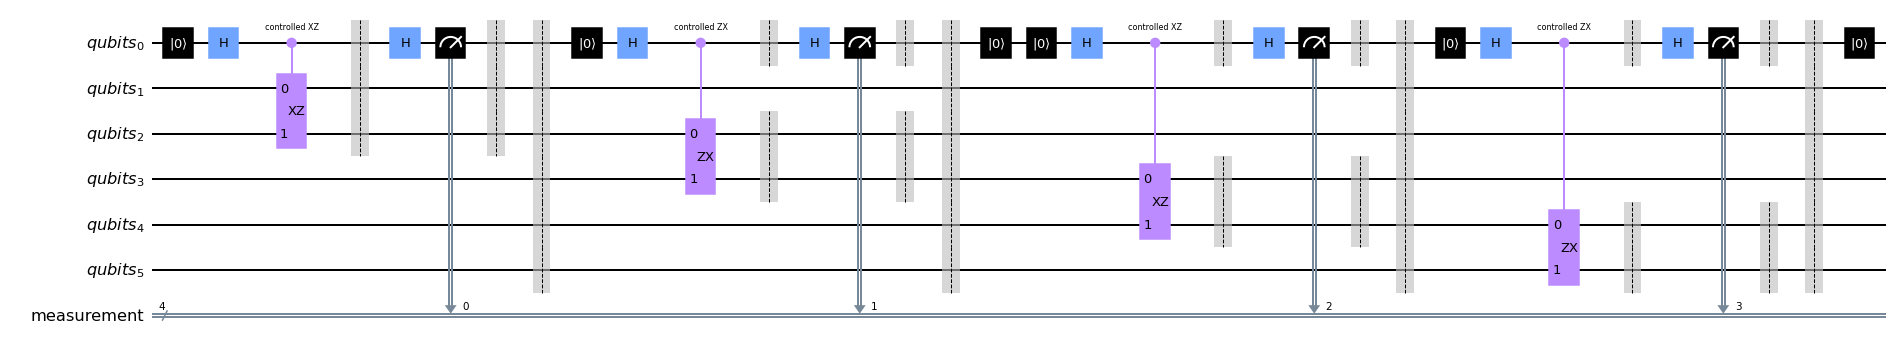

In [137]:
def generate_arc_rep_circ(no_link_bits, start_zx=True, init_codeword=None):
    if no_link_bits % 2 == 0:
        print("sadness, must have odd number of bits")
        return 
    qubits = QuantumRegister(no_link_bits + 1,name="qubits")
    meas_bits = ClassicalRegister((no_link_bits  - 1), name="measurement")
    base_circ = QuantumCircuit(qubits, meas_bits)
    meas_count = 0
    for i in range(1, no_link_bits - 1, 2):
        zx_gate = create_pauli_measurement("ZX")
        xz_gate = create_pauli_measurement("XZ")
        if start_zx:
            base_circ.reset([0])
            base_circ.compose(zx_gate, qubits=[0, i, i+1], clbits=[meas_count],inplace=True )
            base_circ.barrier()
            base_circ.reset([0])
            base_circ.compose(xz_gate, qubits=[0, i+1, i+2], clbits=[meas_count + 1],inplace=True )
            base_circ.barrier()
            base_circ.reset([0])
        else:
            base_circ.reset([0])
            base_circ.compose(xz_gate, qubits=[0, i, i+1], clbits=[meas_count],inplace=True )
            base_circ.barrier()
            base_circ.reset([0])
            base_circ.compose(zx_gate, qubits=[0, i+1, i+2], clbits=[meas_count + 1],inplace=True )
            base_circ.barrier()
            base_circ.reset([0])
        meas_count += 2
    return base_circ
    
acirc = generate_arc_rep_circ(5)
acirc.draw(output="mpl", fold=100)

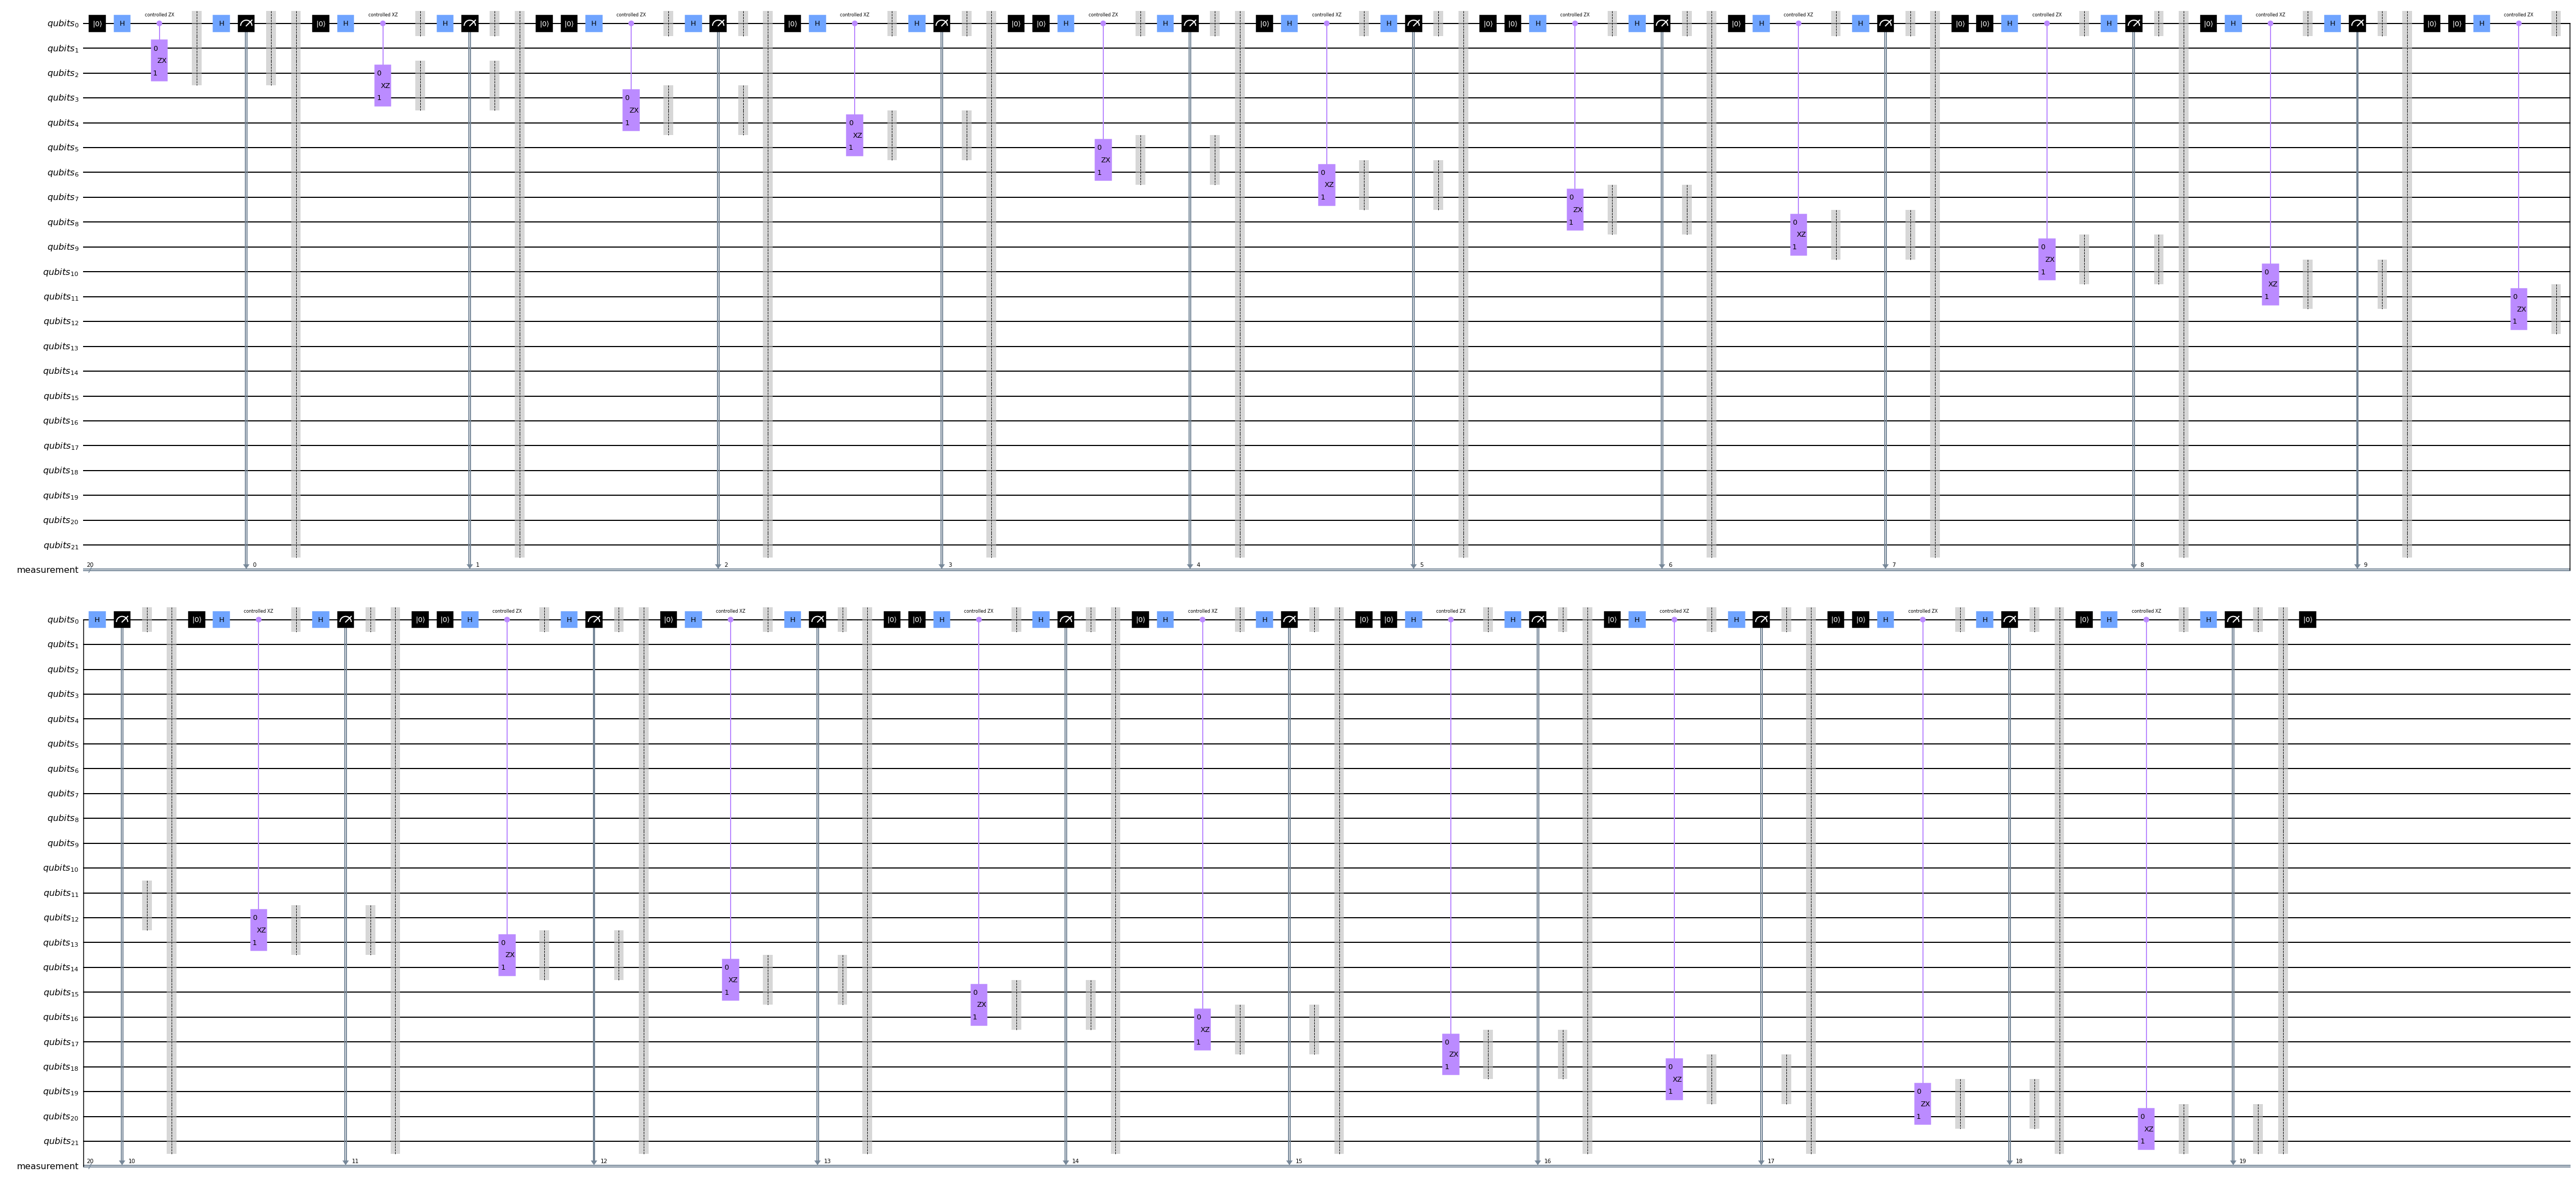

In [107]:
acirc = generate_arc_rep_circ(21,start_zx=False)
acirc.draw(output="mpl", fold=100)




In [112]:
simulator = Aer.get_backend('aer_simulator')
probcirccomp = transpile(acirc, simulator)
job = simulator.run(probcirccomp,shots=99999)
counts = job.result().get_counts()
len(counts)

2048

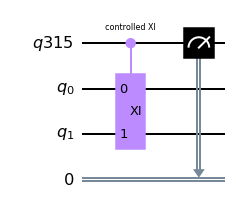

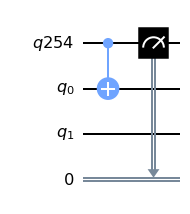

In [78]:
circomp = transpile(circ, simulator)

circomp.draw(output="mpl")

In [141]:
# encoding circuit for stabilizer (xz, zx) for n qubits
def arc_circ_encoding(n, start_zx=True, encoding_only=False):
    # should get n from arccirc in future 
    if encoding_only:
        encoding_circ = QuantumCircuit(QuantumRegister(n, name="data_qubits"))
        mod = 1 if start_zx else 0
        for i in range(n):
            if i %2 == mod: 
                encoding_circ.h(i)
        encoding_circ.barrier()
        return encoding_circ
    encoding_circ = QuantumCircuit(QuantumRegister(1,"ancilla"), QuantumRegister(n, "data qubits"), ClassicalRegister(n-1) )
    mod = 0 if start_zx else 1
    for i in range(1,n + 1):
            if (i %2 == mod): 
                encoding_circ.h(i)
    encoding_circ.barrier()
    return encoding_circ
    
    

In [142]:
n = 3
acirc = generate_arc_rep_circ(n)
#acirc.draw(output="mpl", fold=100)
encoding_circ = arc_circ_encoding(n)
encoding_circ.draw(output="mpl")
encoding_circ.compose(acirc, qubits=range(0,4),inplace=True)
encoding_circ.draw(output="mpl")
encodedcomp = transpile(encoding_circ, simulator)
job = simulator.run(encodedcomp,shots=99999)
counts = job.result().get_counts()
len(counts)
counts

{'00': 99999}

In [144]:
n = 3
acirc = generate_arc_rep_circ(n, start_zx=False)
#acirc.draw(output="mpl", fold=100)
encoding_circ = arc_circ_encoding(n, start_zx=False)
encoding_circ.draw(output="mpl")
encoding_circ.compose(acirc, qubits=range(0,4),inplace=True)
encoding_circ.draw(output="mpl")
encodedcomp = transpile(encoding_circ, simulator)
job = simulator.run(encodedcomp,shots=99999)
counts = job.result().get_counts()
len(counts)
counts

{'00': 99999}

In [146]:
n = 21
start_zx=False
acirc = generate_arc_rep_circ(n, start_zx=start_zx)
#acirc.draw(output="mpl", fold=100)
encoding_circ = arc_circ_encoding(n, start_zx=start_zx)
encoding_circ.draw(output="mpl")
encoding_circ.compose(acirc, qubits=range(0,n+1),inplace=True)
encoding_circ.draw(output="mpl")
encodedcomp = transpile(encoding_circ, simulator)
job = simulator.run(encodedcomp,shots=99999)
counts = job.result().get_counts()
len(counts)
counts

{'00000000000000000000': 99999}

In [147]:
n = 21
start_zx=True
acirc = generate_arc_rep_circ(n, start_zx=start_zx)
#acirc.draw(output="mpl", fold=100)
encoding_circ = arc_circ_encoding(n, start_zx=start_zx)
encoding_circ.draw(output="mpl")
encoding_circ.compose(acirc, qubits=range(0,n+1),inplace=True)
encoding_circ.draw(output="mpl")
encodedcomp = transpile(encoding_circ, simulator)
job = simulator.run(encodedcomp,shots=99999)
counts = job.result().get_counts()
len(counts)
counts

{'00000000000000000000': 99999}